## Sequntial maximum likelihood estimation of infection rate parameters of a single PHU using negative Binomial 

In [6]:

import numpy as np
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import math

from scipy.optimize import minimize

##### CHANGE HERE #############
### Use the time up to which you need to estimate the parameters of sigmoid
dt = 0.1
tstart = 0
tlim = 180
t = np.arange(tstart, tlim, 1)


### keep it always starting at 0
tmoh = np.arange(0, tlim, dt)

ndiv = 1/dt


##### CHANGE HERE #############

###### If you have your own data, load it here #######
### Currently loaded infection data from MOH, for April 2020 to March 2021

PHU_path = './../../../PHU_Data/'
Data = np.zeros([365,4])

files = os.listdir(PHU_path)

target_file1 = f'{PHU_path}/30-Toronto.csv'
target_file2 = f'{PHU_path}/34-York.csv'
target_file3 = f'{PHU_path}/04-Durham.csv'
target_file4 = f'{PHU_path}/22-PeelRegion.csv'

Data[:,0] = np.genfromtxt(target_file1, delimiter=',')
Data[:,1] = np.genfromtxt(target_file2, delimiter=',')
Data[:,2] = np.genfromtxt(target_file3, delimiter=',')
Data[:,3] = np.genfromtxt(target_file4, delimiter=',')


population_by_phu = np.genfromtxt(f'{PHU_path}/population_by_phu.csv', delimiter=',')


N_city = 1
# Preallocate compartments
S = np.zeros((len(tmoh),N_city))
E = np.zeros((len(tmoh),N_city))
I = np.zeros((len(tmoh),N_city))
R = np.zeros((len(tmoh),N_city))
D = np.zeros((len(tmoh),N_city))
N = np.zeros((len(tmoh),N_city))

I_synthetic = np.zeros((len(t),N_city))

##### CHANGE HERE #############
## Observed data

### MOH data - No true solution
# I_synthetic[:,0] =  Data[tstart:tlim,2]

### Synthetic data - true solution
file = np.loadtxt('./durham_synthetic_data_mult.csv')
I_synthetic[:,0] = file[tstart:tlim]

##############################

L_Force = np.zeros((len(tmoh),N_city))

##### CHANGE HERE #############
total = population_by_phu[3,1]
##### CHANGE HERE #############

 
##### CHANGE HERE #############
E[0,0] = Data[0,2]
I[0,0] = Data[0,2]
##############################
R[0,0] = 0
D[0,0] = 0
N[0,0] = total
S[0,0] = N[0,0] - E[0,0] - I[0,0] - R[0,0] - D[0,0]


# Model parameters - Taken from Southern Ontario - COVID MBE paper
gamma_e = 1/15
gamma_i = 1/5
gamma_r = 1/11
gamma_d = 1/750

beta_e = np.zeros((len(tmoh),N_city)) 
beta_i = np.zeros((len(tmoh),N_city))

beta_calibrated = np.zeros((len(tmoh),N_city))


print("initial infected",I[0,0])

print("total population",total)


#### PEEL - 234 , 1451022

#### Toronto - 430 , 2794356

### York - 212, 1173334

### Durham - 94   - 696992


mpl.rcParams.update({'font.size':14})




initial infected 94.0
total population 696992.0


In [10]:

################### Durham ##########################################################
nparam = 4
param = np.ones(nparam)
##### CHANGE HERE ############
### Use the parameters which needs to be included in the sum of sigmoids model for MLE estimation
### When doing sequential calibration, include all the parameters until that time which are already calibrated. 


### Manually Tuned parameters for MOH infection data

################### Durham PHU ##########################################################

# True parameter values with which synthetic data is generated
a0 =   0.14
a1 =  -0.115
t1 =  20
a2 =   0.06
t2 =  35
a3 =   -0.05
t3 = 65
a4 =  0.035
t4 = 90
a5 =  0.06
t5 = 140
# a6 =  -0.075
# t6 = 180
# a7 =  0.06
# t7 = 190
# a8 =  -0.025
# t8 = 250


true_param = [a0,a1,a2,a3,a4,a5]

### Initial guesses of your parameters

a0 =   0.1
a1 =  -0.07
t1 =  20
a2 =   0.02
t2 =  35
a3 =   -0.02
t3 = 65
a4 =  0.06
t4 = 90
a5 =  0.04
t5 = 140

### CHANGE HERE 
beta_i[:,0] = a0  + a1/(1 + np.exp((t1-tmoh))) \
+ a2/(1 + np.exp((t2-tmoh))) \
+ a3/(1 + np.exp((t3-tmoh))) \
+ a4/(1 + np.exp((t4-tmoh))) \
+ a5/(1 + np.exp((t5-tmoh))) \
# + a6/(1 + np.exp((t6-tmoh))) \
# + a7/(1 + np.exp((t7-tmoh))) \
# + a8/(1 + np.exp((t8-tmoh)))

beta_e[:,0] = beta_i[:,0]



#### DEFINE THE PARAMETERS TO BE ESTIMATED 

### CHANGE HERE 
param = np.array([a0,a1,a2,a3,a4,a5])






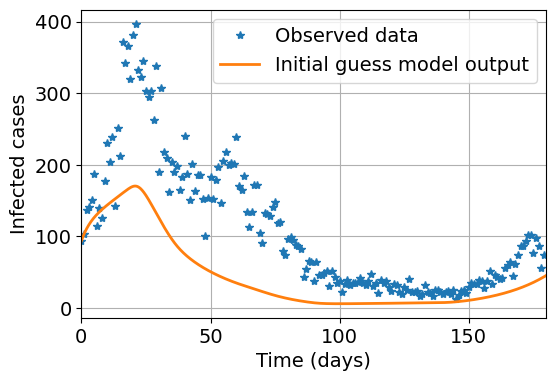

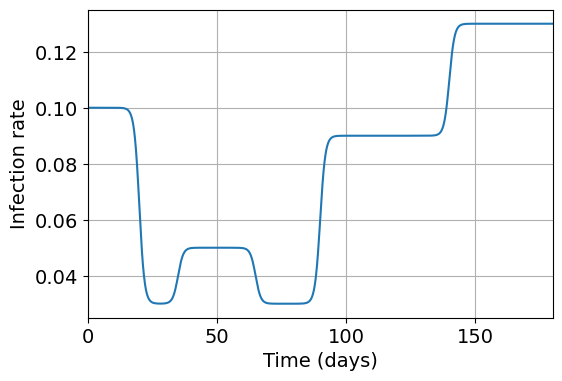

In [11]:
 

FoI = np.zeros((len(tmoh),1))
    
for kk in range(1,len(tmoh)):

  FoI[kk,0] = beta_e[kk-1,0] * (E[kk-1,0] + I[kk-1,0]) / N[kk-1,0]

  S[kk,0] = S[kk-1,0] + dt*(- FoI[kk,0] * S[kk-1,0])
  E[kk,0] = E[kk-1,0] + dt*(FoI[kk,0]*S[kk-1,0] - (gamma_i + gamma_e)*E[kk-1,0])
  
  I[kk,0] = I[kk-1,0] + dt*(gamma_i*E[kk-1,0] - (gamma_r + gamma_d)*I[kk-1,0])
  R[kk,0] = R[kk-1,0] + dt*(gamma_e*E[kk-1,0] + gamma_r*I[kk-1,0])
  D[kk,0] = D[kk-1,0] + dt*(gamma_d*I[kk-1,0])
  N[kk,0] = S[kk,0] +  E[kk,0] + I[kk,0] + R[kk,0]

  if( kk%ndiv == 0):
      idxmoh = int(kk/ndiv)



fig1, ax1 = plt.subplots(figsize=(6, 4))
ax1.set_xlim([0,tlim])
ax1.set_xlabel('Time (days)')
ax1.set_ylabel('Infected cases') 
ax1.grid()
plt.plot(t, I_synthetic[:,0], '*', markersize=6, label='Observed data')
plt.plot(tmoh, I[:,0], '-',linewidth=2, label='Initial guess model output')
ax1.legend(loc='best')
# plt.savefig('./figs/noisy_data.pdf',  bbox_inches='tight')
plt.show()



fig2, ax2 = plt.subplots(figsize=(6, 4))
ax2.set_xlim([0,tlim])
ax2.set_xlabel('Time (days)')
ax2.set_ylabel('Infection rate') 
ax2.grid()
plt.plot(tmoh, beta_i[:,0], label='Sum of sigmoid model')
ax1.legend(loc='best')
# plt.savefig('./figs/beta.pdf',  bbox_inches='tight')
plt.show()




### Applying scipy optimization library

In [12]:

#### CHANGE HERE 
### decrease p to reduce r and thus dispersion, increase p to get more dispersion
sigma = 0.2 # probability of success


def loglikelihood(param):
      
    idxmoh = 1
    idxdata= 0

    loglik = 0

    FoI = np.zeros((len(tmoh),1))

############### CHANGE HERE #################
###### Update the model of beta to include the parameter which needs to be estimated along with the known paramters until that time
    beta_i[:,0] = param[0] + param[1]/(1 + np.exp((t1-tmoh))) + param[2]/(1 + np.exp((t2-tmoh)))  \
    + param[3]/(1 + np.exp((t3-tmoh))) \
     + param[4]/(1 + np.exp((t4-tmoh))) \
     + param[5]/(1 + np.exp((t5-tmoh))) \
    # + param[6]/(1 + np.exp((t6-tmoh))) \
    # + param[7]/(1 + np.exp((t7-tmoh))) \
    # + param[8]/(1 + np.exp((t8-tmoh)))
    

    beta_e[:,0] = beta_i[:,0]   

    for kk in range(1,len(tmoh)):

            FoI[kk,0] = beta_e[kk-1,0] * (E[kk-1,0] + I[kk-1,0]) / N[kk-1,0]

            S[kk,0] = S[kk-1,0] + dt*(- FoI[kk,0] * S[kk-1,0])
            E[kk,0] = E[kk-1,0] + dt*(FoI[kk,0]*S[kk-1,0] - (gamma_i + gamma_e)*E[kk-1,0])
            I[kk,0] = I[kk-1,0] + dt*(gamma_i*E[kk-1,0] - (gamma_r + gamma_d)*I[kk-1,0])
            R[kk,0] = R[kk-1,0] + dt*(gamma_e*E[kk-1,0] + gamma_r*I[kk-1,0])
            D[kk,0] = D[kk-1,0] + dt*(gamma_d*I[kk-1,0])
            N[kk,0] = S[kk,0] +  E[kk,0] + I[kk,0] + R[kk,0]


            ## For collecting the model output only at data points
            if( kk%ndiv == 0 ):
                idxmoh = int(kk/ndiv)


                if(tstart != 0):

                    if(idxmoh >= tstart and idxmoh < tlim):
                         

                        multiplier = (1/(np.sqrt(2*np.pi)*sigma * I[kk,0]))


                        err = (I_synthetic[idxdata,0] - I[kk,0])**2

                        # log likelihood
                        loglik = loglik  + np.log(multiplier) - (err/(2*(sigma * I[kk,0])**2)) 

                        idxdata+=1
            
                else:

                    multiplier = (1/(np.sqrt(2*np.pi)*sigma * I[kk,0]))


                    err = (I_synthetic[idxmoh,0] - I[kk,0])**2

                    # log likelihood
                    loglik = loglik  + np.log(multiplier) - (err/(2*(sigma * I[kk,0])**2)) 

                    if(np.isnan(loglik)):
                        print('beta', beta_i[kk,0])
                        print('infected', I[kk,0])
                        print('param ',param)
                        print('log lik', loglik)


    return -loglik




options_bfgs = {
    'gtol': 1e-12,  # Gradient norm tolerance for convergence
    'disp': True,  # Display convergence messages
    'eps': 1e-8
}

options_nm = {
    'disp': True,  # Display convergence messages
}

val = 0.05
bounds = [(a0-val, a0+val), (a1-val, a1+val),(a2-val, a2+val),(a3-val, a3+val),(a4-val, a4+val),(a5-val, a5+val)]


### To be used for Synthetic data when you know true parameter values
# errors = []
# iterations = []

# def callback(xk):
#     print(f"Current parameter values: {xk}")
#     # err = np.linalg.norm(xk - trueparam)/np.linalg.norm(trueparam)
#     # print("relative error is", err)
#     errors.append(err)
#     iterations.append(len(errors))



res = minimize(loglikelihood, param,method='L-BFGS-B', bounds=bounds, options = options_bfgs)

# res = minimize(loglikelihood, param,method='Nelder-Mead',bounds=bounds, options=options_nm)

### To be used for Synthetic data when you know true parameter values
# path = './figs'
# filepath =  os.path.join(path,'relative_error.pdf')
# # Plot the error vs iteration
# # plt.figure()
# # plt.plot(iterations, errors, marker='o')
# # plt.xlabel('Iteration')
# # plt.ylabel('Relative error norm')
# # # plt.title('Relative error norm vs iteration')
# # plt.grid(True)
# # plt.savefig(filepath)
# # plt.show()


print(res)
param_mle = res.x

print("initial guesses" ,param)
print("MLE value", res.x)
print("True value", true_param)

        

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.72070D+04    |proj g|=  5.00000D-02

At iterate    1    f=  3.22487D+03    |proj g|=  1.00000D-01

At iterate    2    f=  3.05755D+03    |proj g|=  1.00000D-01

At iterate    3    f=  3.05358D+03    |proj g|=  9.94519D-02

At iterate    4    f=  2.88794D+03    |proj g|=  1.00000D-01

At iterate    5    f=  2.82564D+03    |proj g|=  1.00000D-01

At iterate    6    f=  2.70075D+03    |proj g|=  1.00000D-01
  Positive dir derivative in projection 
  Using the backtracking step 

At iterate    7    f=  2.25971D+03    |proj g|=  9.99932D-02

At iterate    8    f=  2.25802D+03    |proj g|=  9.98714D-02
  Positive dir derivative in projection 
  Using the backtracking step 

At iterate    9    f=  2.14949D+03    |proj g|=  9.96000D-02

At iterate   10    f=  2.08098D+03    |proj g|=  1.00000D-01

At ite

### MLE Fit

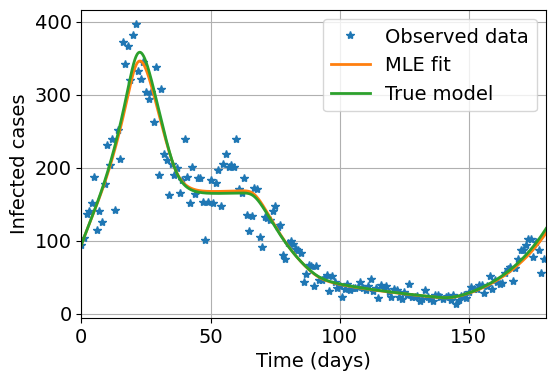

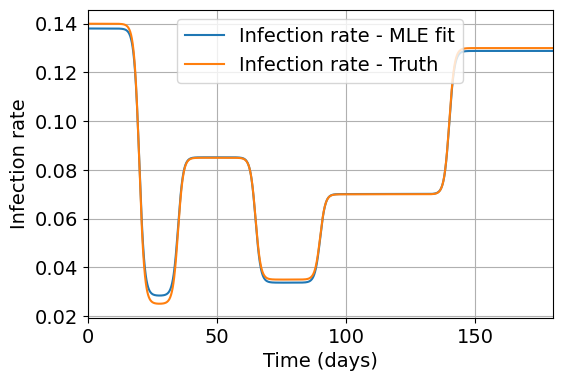

In [13]:



########### CHANGE HERE #############
### Add the necessary parameter values which are already calibrated along with the current parameters ##############

beta_i[:,0] = param_mle[0] +  param_mle[1]/(1 + np.exp((t1-tmoh)))  \
+ param_mle[2]/(1 + np.exp((t2-tmoh))) \
+ param_mle[3]/(1 + np.exp((t3-tmoh))) \
+ param_mle[4]/(1 + np.exp((t4-tmoh))) \
+ param_mle[5]/(1 + np.exp((t5-tmoh))) \
# + param_mle[6]/(1 + np.exp((t6-tmoh))) \
# + param_mle[7]/(1 + np.exp((t7-tmoh))) \
# + param_mle[8]/(1 + np.exp((t8-tmoh)))



###########################################

beta_e[:,0] = beta_i[:,0]
 

FoI = np.zeros((len(tmoh),1))
    
for kk in range(1,len(tmoh)):

  FoI[kk,0] = beta_e[kk-1,0] * (E[kk-1,0] + I[kk-1,0]) / N[kk-1,0]

  S[kk,0] = S[kk-1,0] + dt*(- FoI[kk,0] * S[kk-1,0])
  E[kk,0] = E[kk-1,0] + dt*(FoI[kk,0]*S[kk-1,0] - (gamma_i + gamma_e)*E[kk-1,0])
  
  I[kk,0] = I[kk-1,0] + dt*(gamma_i*E[kk-1,0] - (gamma_r + gamma_d)*I[kk-1,0])
  R[kk,0] = R[kk-1,0] + dt*(gamma_e*E[kk-1,0] + gamma_r*I[kk-1,0])
  D[kk,0] = D[kk-1,0] + dt*(gamma_d*I[kk-1,0])
  N[kk,0] = S[kk,0] +  E[kk,0] + I[kk,0] + R[kk,0]


## load saved true infection data

file = np.loadtxt('./durham_synthetic_true_mult.csv')
I_truth = file[0:len(tmoh)]

fig1, ax1 = plt.subplots(figsize=(6, 4))
plt.plot(t[:tlim], I_synthetic[:tlim,0], '*', markersize=6, label='Observed data')
plt.plot(tmoh[:int(tlim*ndiv)], I[:int(tlim*ndiv),0], '-',linewidth=2, label='MLE fit')
plt.plot(tmoh[:int(tlim*ndiv)], I_truth, '-',linewidth=2, label='True model')
plt.legend(loc='best')
plt.xlabel('Time (days)')
plt.xlim([0,tlim])
plt.ylabel('Infected cases')
plt.grid()
plt.savefig('./figs/MLE_fit.pdf', bbox_inches='tight')
plt.show()


## load saved true model of beta

file = np.loadtxt('./durham_synthetic_true_beta_mult.csv')
beta_truth = file[0:len(tmoh)]


fig2, ax2 = plt.subplots(figsize=(6, 4))
ax2.set_xlim([0,tlim])
ax2.set_xlabel('Time (days)')
ax2.set_ylabel('Infection rate') 
ax2.grid()
plt.plot(tmoh, beta_i[:,0], label='Infection rate - MLE fit')
plt.plot(tmoh, beta_truth, label='Infection rate - Truth')
plt.legend(loc='best')
plt.savefig('./figs/beta_fit.pdf',  bbox_inches='tight')
plt.show()

